In [1]:
from src.SensitivityAnalysis import load_data
import matplotlib.pyplot as plt
import pandas as pd
from src.SugarScape import SugarScape
from mesa import batch_run
import numpy as np
from tqdm import tqdm

# Finding Parameters

In [ ]:
data = load_data()
averaged = []
for i in range(len(data) // 10 - 1):
    trader_mean = data['Trader Count'].iloc[i*10:(i+1)*10].mean()
    gini_mean = data['Gini'].iloc[i*10:(i+1)*10].mean()
    
    if trader_mean > 0:
        averaged.append(1 / gini_mean * trader_mean)


In [ ]:
# Find where gini maximized 
worst = dict(data.iloc[np.argmin(averaged)])
best = dict(data.iloc[np.argmax(averaged)])

worst = {key: float(value) for (key,value) in worst.items()}
best = {key: float(value) for (key,value) in best.items()}

print(f'Worst case: {worst}')
print(f'Best case: {best}')

# Find closest to average
dist = (averaged - np.mean(averaged))**2
idx = np.argmin(dist)

typical = dict(data.iloc[idx * 10])
typical = {key: float(value) for (key,value) in typical.items()}
print(f'Typical: {typical}')


# Run Base Simulations

In [31]:
## USe these map schemes based on your name
# Priyank: top-heavy
# Amish: uniform
# Ilia: split

map_scheme = 'uniform'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]

results = []
replicates = 30
max_steps = 200

In [32]:
for scenario in scenarios:
    batch = batch_run(SugarScape, scenario, number_processes=None,
                      iterations=replicates, max_steps=max_steps, display_progress=True, data_collection_period=1)
    for i in range(replicates):
        scenario["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
        scenario["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]

        results.append(list(scenario.values()))

# Convert to df and save
names = list(scenario.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Experiments/Base/results_{map_scheme}.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

NameError: name 'scenarios' is not defined

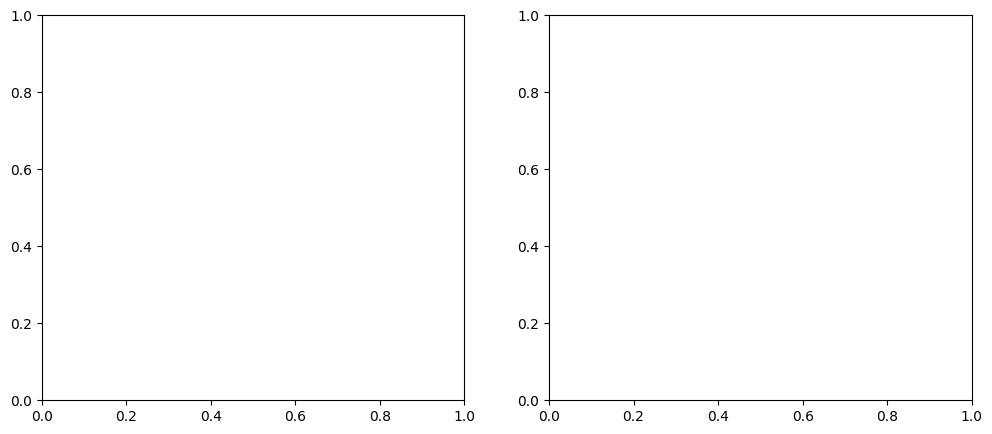

In [3]:
def safe_eval(value):
    try:
        return eval(value)
    except:
        return value

names = ['Worst', 'Best', 'Typical', 'Balanced', 'Slow evolving', 'Fast evolving']
for map_scheme in ['uniform', 'top_heavy', 'split']:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    df = pd.read_csv(f'Experiments/Base/results_{map_scheme}.csv')
    df['Gini'] = df['Gini'].apply(safe_eval)
    df['Trader Count'] = df['Trader Count'].apply(safe_eval)
    
    for i in range(len(scenarios)):
        # Get gini and trader count of every scenario
        gini = df.iloc[i*replicates:(i+1)*replicates]['Gini']
        trader = df.iloc[i*replicates:(i+1)*replicates]['Trader Count']
        
        # Convert to 2d np arrays
        gini = np.vstack(gini)
        trader = np.vstack(trader)
        
        # Get means and ci
        gini_mean = np.mean(gini, axis=0)
        gini_ci = np.std(gini, ddof=1, axis=0) / replicates * 1.96
        trader_mean = np.mean(trader, axis=0)
        trader_ci = np.std(trader, ddof=1, axis=0) / replicates * 1.96
        
        # Plotting
        x = np.arange(len(gini_mean))
        ax[0].plot(x, gini_mean, label=names[i])
        ax[0].fill_between(x, gini_mean + gini_ci, gini_mean - gini_ci, alpha=0.5)
        ax[1].plot(x, trader_mean, label=names[i])
        ax[1].fill_between(x, trader_mean + trader_ci, trader_mean - trader_ci, alpha=0.5)
    
    # Set labels, grid and title
    ax[1].legend(bbox_to_anchor=(1, 1.05))
    ax[0].set_title('Gini')
    ax[1].set_title('Trader Count')
    for i in range(2):
        ax[i].grid()
        ax[i].set_xlabel('Timesteps')
    ax[0].set_ylabel('Gini Coefficient')
    ax[1].set_ylabel('Number of Traders')
    
    # Save figure
    fig.suptitle(f'{map_scheme}')
    fig.tight_layout()
    fig.savefig(f'Experiments/Base/plot_{map_scheme}.png', dpi=300, bbox_inches='tight')

# Running Experiments

In [5]:
## Use these map schemes based on your name
# Priyank: top-heavy
# Amish: uniform
# Ilia: split

map_scheme = 'uniform'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]


tax_systems = [
    ("progressive", "needs"),
    ("flat", "flat"),
    ("regressive", "random"),
    ("luxury", "progressive"),
    ("progressive", "progressive")
]

tax_rates = [0.1, 0.25, 0.4]

results = []
replicates = 30
max_steps = 200

In [ ]:
with tqdm(total=len(scenarios), ncols=70) as pbar:
    for scenario in scenarios:
        for tax_system in tax_systems:
            for tax_rate in tax_rates:
                scenario_copy = scenario.copy()
                # Adding taxsystem and rate into scenario
                scenario_copy['tax_scheme'] = tax_system[0]
                scenario_copy['distributer_scheme'] = tax_system[1]
                scenario_copy['tax_rate'] = tax_rate
        
                batch = batch_run(SugarScape, scenario_copy, number_processes=None,
                                  iterations=replicates, max_steps=max_steps, display_progress=False, data_collection_period=1)
                for i in range(replicates):
                    scenario_copy["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
                    scenario_copy["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
    
                results.append(list(scenario_copy.values()))
    
        pbar.update(1)

# Convert to df and save
names = list(scenario_copy.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Experiments/results_{map_scheme}.csv')

# Updated Final Experiment

In [2]:
import logging
from multiprocessing import Pool, cpu_count
# from src.SugarScape import SugarScape, batch_run

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

map_scheme = 'top_heavy'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]

tax_systems = [
    ("progressive", "needs"),
    ("flat", "flat"),
    ("regressive", "random"),
    ("luxury", "progressive"),
    ("progressive", "progressive")
]

tax_rates = [0.1, 0.25, 0.4]

results = []
replicates = 10
max_steps = 200

def run_experiment(scenario):
    """Run the SugarScape model with given parameters and return results."""
    logger = setup_logger()
    results = []
    for tax_system in tax_systems:
        for tax_rate in tax_rates:
            scenario_copy = scenario.copy()
            scenario_copy['tax_scheme'] = tax_system[0]
            scenario_copy['distributer_scheme'] = tax_system[1]
            scenario_copy['tax_rate'] = tax_rate
            
            logger.info(f"Running experiment: {scenario_copy}")
            batch = batch_run(SugarScape, scenario_copy, number_processes=None,
                              iterations=replicates, max_steps=max_steps, display_progress=False, data_collection_period=1)
            for i in range(replicates):
                scenario_result = scenario_copy.copy()
                scenario_result["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
                scenario_result["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
                results.append(list(scenario_result.values()))
    return results

with tqdm(total=len(scenarios), ncols=70) as pbar:
    for scenario in scenarios:
        results.extend(run_experiment(scenario))
        pbar.update(1)

# Convert to df and save
names = list(scenario.keys()) + ['tax_scheme', 'distributer_scheme', 'tax_rate', 'Gini', 'Trader Count']
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Experiments/results_v4_{map_scheme}.csv', index=False)


100%|██████████████████████████████████| 6/6 [21:16<00:00, 212.77s/it]


# Plotting Time Series

In [6]:
# Set path to results
%matplotlib agg
path = 'Experiments/results_v4_'
map_schemes = ['split', 'top_heavy', 'uniform']

for map_scheme in map_schemes:
    data = pd.read_csv(f'{path}{map_scheme}.csv')
    
    # Convert trader count and gini to lists
    data['Trader Count'] = data['Trader Count'].apply(safe_eval)
    data['Gini'] = data['Gini'].apply(safe_eval)
    
    # Group to find different scenarios
    keys = ['vision_mean', 'metabolism_mean', 'max_age_mean', 'repopulate_factor', 'cell_regeneration']
    groups = data.groupby(keys)
    
    # Matching group names to scenarios
    name_scenarios = ['Worst', 'Best', 'Typical', 'Balanced', 'Slow evolving', 'Fast evolving']
    matches = {}
    for name, values in groups:
        for i, scenario in enumerate(scenarios):
            if all(scenario[key] == name[j] for j, key in enumerate(keys)):
                matches[name_scenarios[i]] = values.reset_index()
                break
    
    for case in name_scenarios:
        scenario = matches[case]
        
        # Group by rate
        scenario = scenario.groupby(['tax_rate'])
            
        # Create figure
        fig, ax = plt.subplots(3, 2, figsize=(9, 10))
        
        for i, (name, values) in enumerate(scenario):
            # Group by tax system
            values = values.groupby(['tax_scheme', 'distributer_scheme'])
            
            for name2, values2 in values:
                gini = np.vstack(values2['Gini'])
                trader = np.vstack(values2['Trader Count'])
                
                # Get means and ci
                gini_mean = np.mean(gini, axis=0)
                gini_ci = np.std(gini, ddof=1, axis=0) / np.sqrt(gini.shape[0]) * 1.96
                trader_mean = np.mean(trader, axis=0)
                trader_ci = np.std(trader, ddof=1, axis=0) / np.sqrt(gini.shape[0]) * 1.96
                
                # Plotting Gini
                label = f'{name2[0].capitalize()} - {name2[1].capitalize()}'
                x = np.arange(len(gini_mean))
                ax[i, 0].plot(x, gini_mean, label=label)
                ax[i, 0].fill_between(x, gini_mean + gini_ci, gini_mean - gini_ci, alpha=0.5)
                ax[i, 0].grid()
                ax[i, 0].set_title(f'Gini - {name[0] * 100}%')
                ax[i, 0].set_ylabel('Gini Coefficient')
                
                # Plotting Trader Count         
                ax[i, 1].plot(x, trader_mean, label=label)
                ax[i, 1].fill_between(x, trader_mean + trader_ci, trader_mean - trader_ci, alpha=0.5)
                ax[i, 1].grid()
                ax[i, 1].set_title(f'Trader Count - {name[0] * 100}%')
                ax[i, 1].set_ylabel('Number of Traders')
                
                if i < 2:
                    # Remove xtick labels
                    ax[i, 0].set_xticklabels([])
                    ax[i, 1].set_xticklabels([])
                else:
                    ax[i, 0].set_xlabel('Timesteps')
                    ax[i, 1].set_xlabel('Timesteps')
        
        # Place legend in bottom right and make legend smaller
        ax[0, 0].legend(loc='lower right')
        ax[0, 1].legend(loc='lower right')
        fig.suptitle(f'{map_scheme.capitalize()} - {case.capitalize()}')
        fig.tight_layout()
    
        print(f'Saving {case} for {map_scheme}')
        fig.savefig(f'Experiments/time_plots/{map_scheme}_{case}.png', dpi=300, bbox_inches='tight')
        plt.close()


Saving Worst for split
Saving Best for split
Saving Typical for split
Saving Balanced for split
Saving Slow evolving for split
Saving Fast evolving for split
Saving Worst for top_heavy
Saving Best for top_heavy
Saving Typical for top_heavy
Saving Balanced for top_heavy
Saving Slow evolving for top_heavy
Saving Fast evolving for top_heavy
Saving Worst for uniform
Saving Best for uniform
Saving Typical for uniform
Saving Balanced for uniform
Saving Slow evolving for uniform
Saving Fast evolving for uniform


# Plotting Boxplots

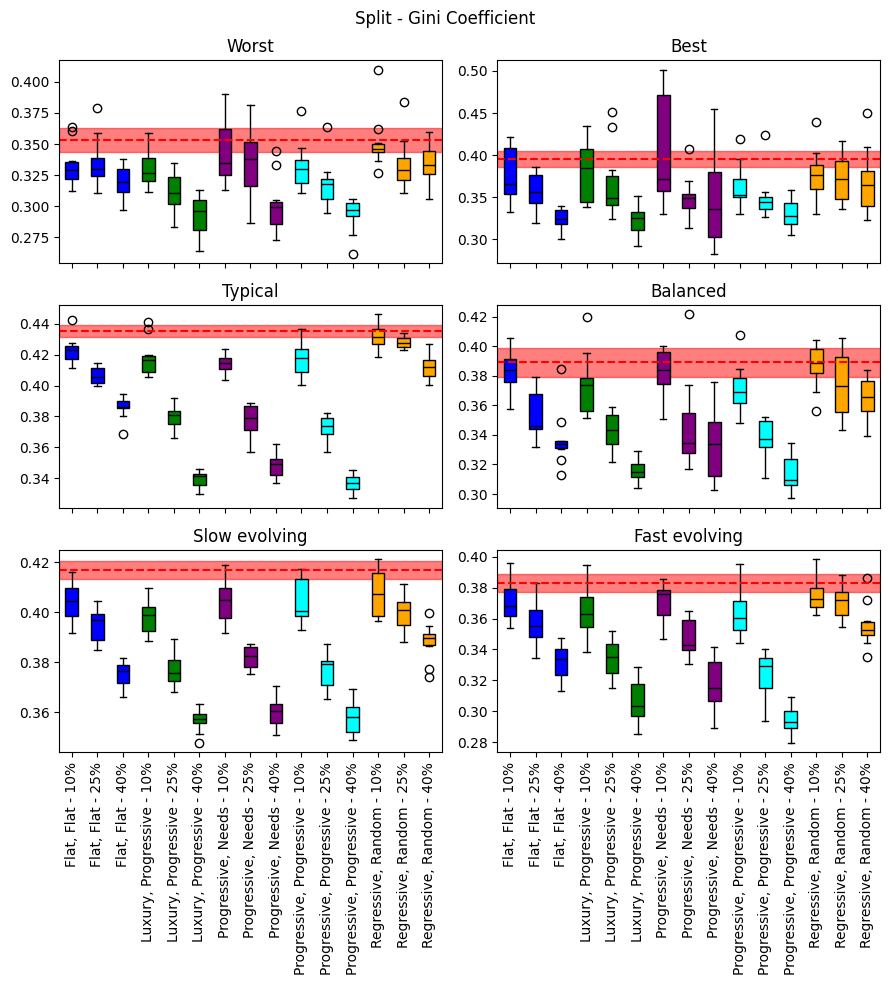

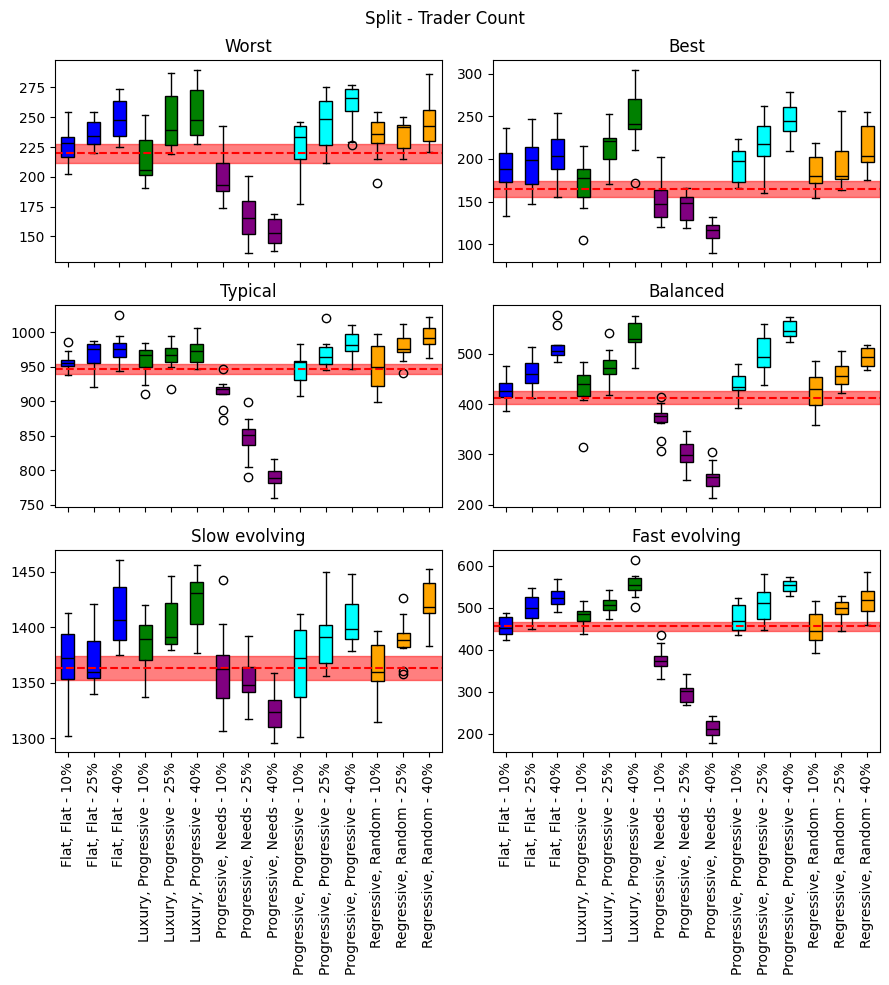

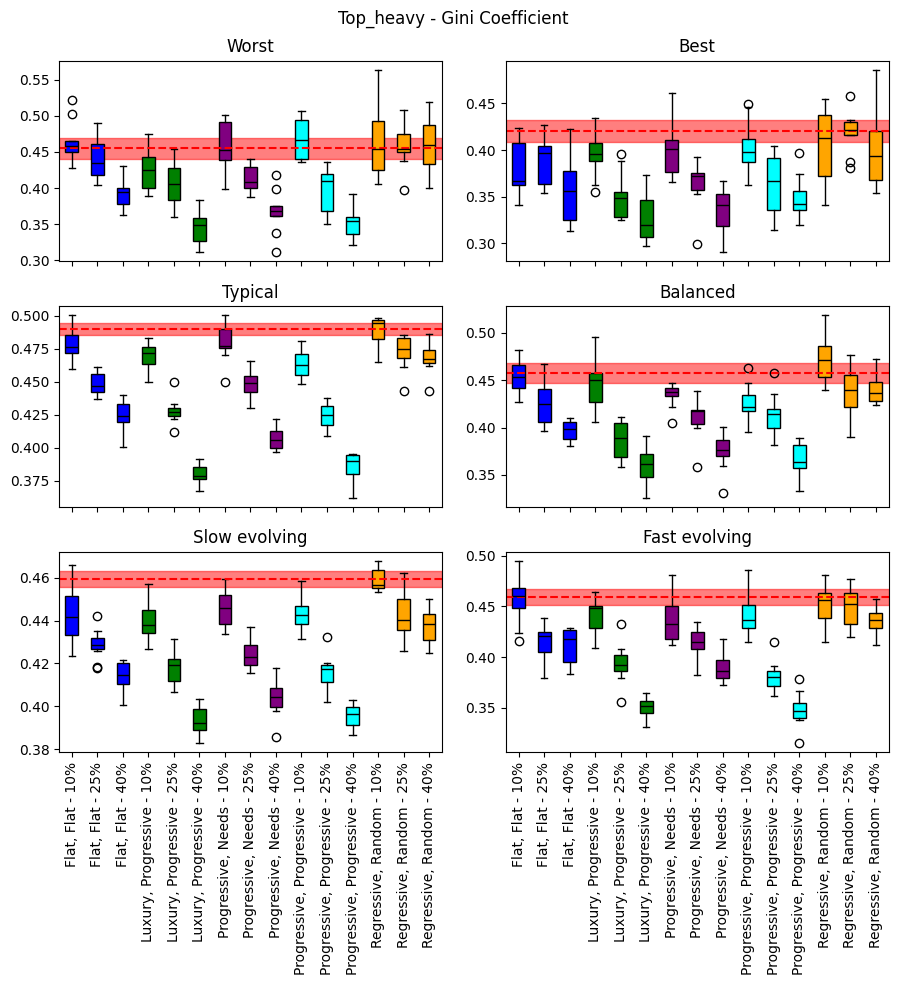

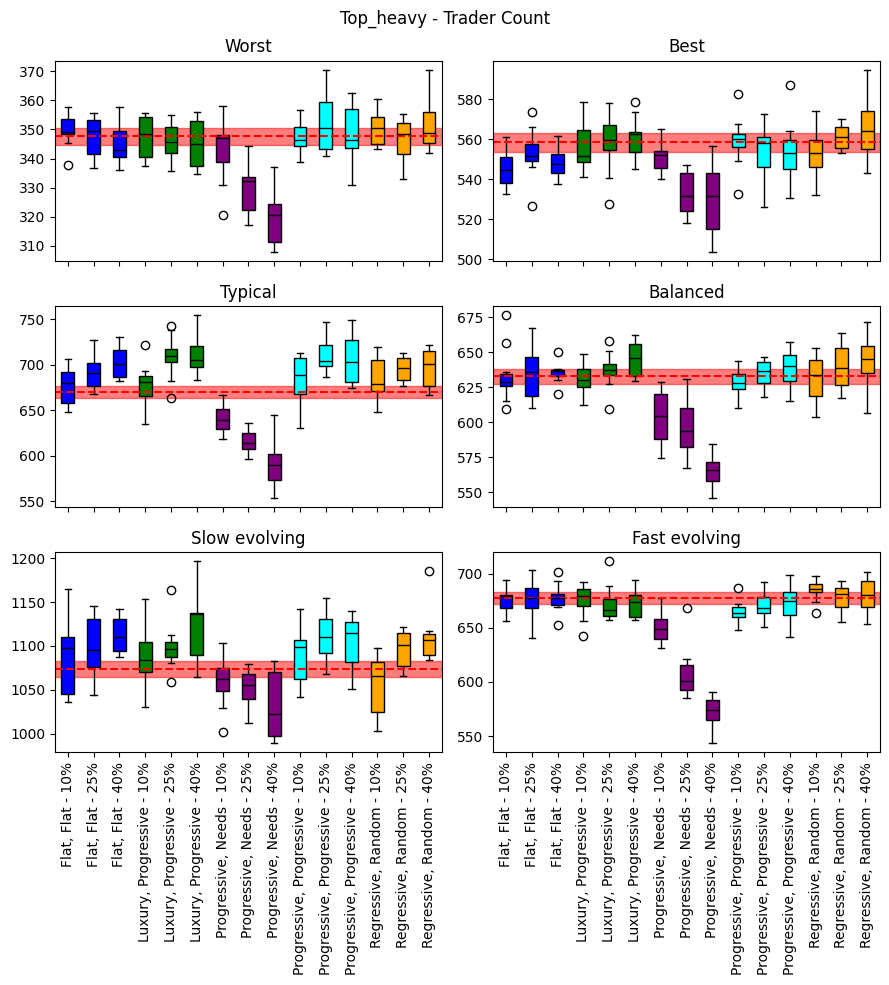

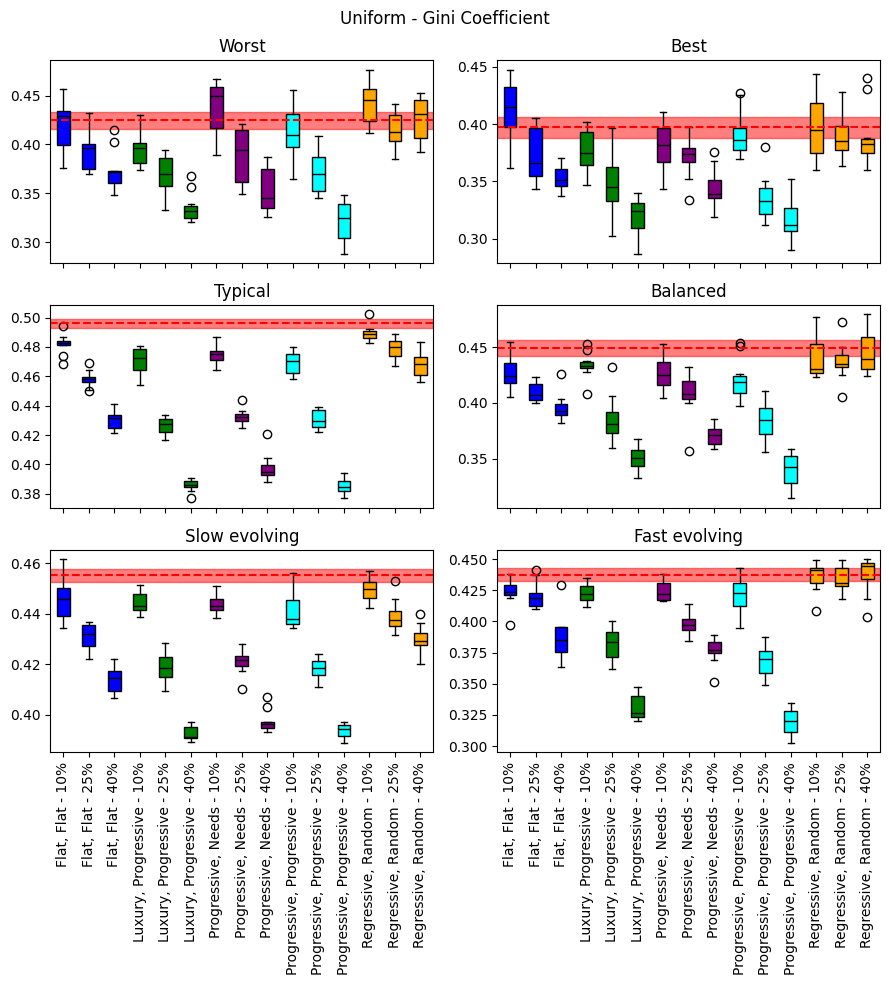

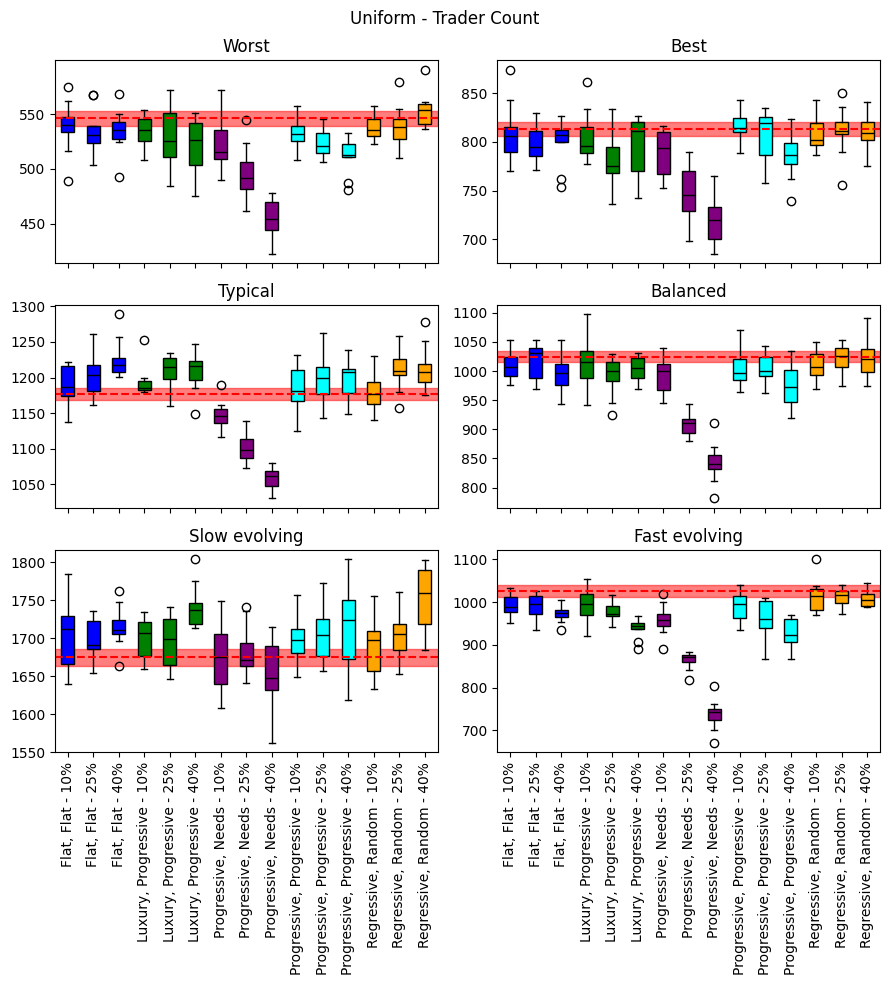

In [7]:
%matplotlib inline
map_schemes = ['split', 'top_heavy', 'uniform']
base_path = 'Experiments/Base/results_'
path = 'Experiments/results_v4_'


def boxplot(ax, boxes, mean, ci):
    # Plotting
    box = ax.boxplot(boxes.values(), tick_labels=boxes.keys(), patch_artist=True)
    
    # Remove xlabels from all but last 2
    if i < 4:
        ax.set_xticklabels([])
    else:
        # Rotate x labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    
    ax.set_title(f'{case.capitalize()}')
    
    # Add base line
    ax.axhline(mean, color='r', linestyle='--', label='Base')
    ax.axhspan(mean + ci, mean - ci, color='r', alpha=0.5)
    
    # Set boxplot colors in groups of three
    colors = ['blue', 'green', 'purple', 'cyan', 'orange']
    for j, patch in enumerate(box['boxes']):
        color = colors[j // 3]
        patch.set_facecolor(color)
        
    # Set median bar color
    for median in box['medians']:
        median.set_color('black')
    
    return ax

for map_scheme in map_schemes:
    data = pd.read_csv(f'{path}{map_scheme}.csv')
    base = pd.read_csv(f'{base_path}{map_scheme}.csv')

    # Convert trader count and gini to lists
    data['Trader Count'] = data['Trader Count'].apply(safe_eval)
    data['Gini'] = data['Gini'].apply(safe_eval)
    base['Trader Count'] = base['Trader Count'].apply(safe_eval)
    base['Gini'] = base['Gini'].apply(safe_eval)
    
    # Group to find different scenarios
    keys = ['vision_mean', 'metabolism_mean', 'max_age_mean', 'repopulate_factor', 'cell_regeneration']
    groups = data.groupby(keys)
    groups_base = base.groupby(keys)
    
    # Matching group names to scenarios
    name_scenarios = ['Worst', 'Best', 'Typical', 'Balanced', 'Slow evolving', 'Fast evolving']
    matches = {}
    matches_base = {}
    for name, values in groups:
        for i, scenario in enumerate(scenarios):
            if all(scenario[key] == name[j] for j, key in enumerate(keys)):
                matches[name_scenarios[i]] = values.reset_index()
                break
    
    for name, values in groups_base:
        for i, scenario in enumerate(scenarios):
            if all(scenario[key] == name[j] for j, key in enumerate(keys)):
                matches_base[name_scenarios[i]] = values.reset_index()
                break
                
    # Create figures
    fig_gini, ax_gini = plt.subplots(3, 2, figsize=(9, 10))
    ax_gini = ax_gini.flatten()
    
    fig_trader, ax_trader = plt.subplots(3, 2, figsize=(9, 10))
    ax_trader = ax_trader.flatten()
    
    for i, case in enumerate(name_scenarios):
        # Get data
        scenario = matches[case]
        scenario_base = matches_base[case]
        
        # Get gini and trader count for base
        gini_base = np.vstack(scenario_base['Gini'])
        trader_base = np.vstack(scenario_base['Trader Count'])
        
        # Get means
        gini_base = np.mean(gini_base[:, -20:], axis=1)
        trader_base = np.mean(trader_base[:, -20:], axis=1)
        
        # Convert to mean and ci
        gini_base_mean = np.mean(gini_base)
        gini_base_ci = np.std(gini_base, ddof=1) / np.sqrt(gini_base.shape[0]) * 1.96
        trader_base_mean = np.mean(trader_base)
        trader_base_ci = np.std(trader_base, ddof=1) / np.sqrt(gini_base.shape[0]) * 1.96
        
        # Group based by tax system
        scenario = scenario.groupby(['tax_scheme', 'distributer_scheme'])
        
        gini_boxes = {}
        trader_boxes = {}
        for name, values in scenario:
            # Group by tax rate
            values = values.groupby(['tax_rate'])
            
            for name2, values2 in values:
                # Get gini and trader
                gini = np.vstack(values2['Gini'])
                trader = np.vstack(values2['Trader Count'])
                
                # Get means
                gini_mean = np.mean(gini[:, -20:], axis=1)
                trader_mean = np.mean(trader[:, -20:], axis=1)
                
                # Add to boxes
                label = f'{name[0].capitalize()}, {name[1].capitalize()} - {name2[0] * 100:.0f}%'
                gini_boxes[label] = gini_mean
                trader_boxes[label] = trader_mean
        
        ax_gini[i] = boxplot(ax_gini[i], gini_boxes, gini_base_mean, gini_base_ci)
        ax_trader[i] = boxplot(ax_trader[i], trader_boxes, trader_base_mean, trader_base_ci)
        
    fig_gini.suptitle(f'{map_scheme.capitalize()} - Gini Coefficient')
    fig_trader.suptitle(f'{map_scheme.capitalize()} - Trader Count')
    
    fig_gini.tight_layout()
    fig_trader.tight_layout()
    
    fig_gini.savefig(f'Experiments/boxplots/{map_scheme}_gini.png', dpi=300, bbox_inches='tight')
    fig_trader.savefig(f'Experiments/boxplots/{map_scheme}_trader.png', dpi=300, bbox_inches='tight')
            
            
            


/tmp/ipykernel_3981/3501621081.py:2: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


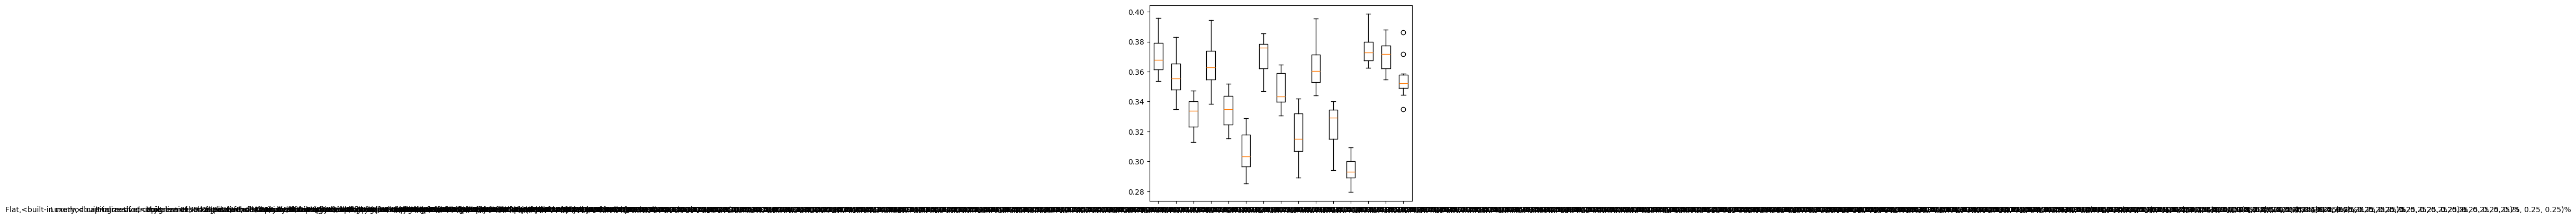

In [185]:
plt.boxplot(gini_boxes.values(), tick_labels=gini_boxes.keys())
plt.tight_layout()

In [30]:
print(base['max_age_mean'] == 70)

60


In [194]:
print(name2)

(0.4,)
